<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook aims to bring together the df and loaded files to implement them in a Deep Learning Model**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
from sklearn.model_selection import train_test_split
import nibabel as nb
import seaborn as sns

In [0]:
# imports for keras model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils, generic_utils
from keras.layers import LeakyReLU
from keras import regularizers

In [20]:
from google.colab import drive

# mount google drive into google colab
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where the data is
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


**Load Dataframe and Pickle**

In [0]:
patient_df = pd.read_pickle('processed_patient_df.pkl')

with open('total_slices_all.pkl', 'rb') as f:
    total_slices, total_slices_info = pickle.load(f)

In [22]:
np.shape(total_slices)

(102, 200, 200, 160, 1)

In [23]:
# establish control and pd df's
df_control = patient_df[patient_df.Group == 0] 
df_pd = patient_df[patient_df.Group == 1] 

patient_df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
197,353477,3750,0,M,54,5,MRI,MPRAGE GRAPPA,Original,10/10/2012,DCM,NaN
198,368584,3638,1,M,66,1,MRI,SAG T1 3D MPRAGE,Original,4/02/2013,DCM,NaN
199,363979,3637,0,M,57,1,MRI,SAG T1 3D MPRAGE,Original,2/27/2013,DCM,NaN
200,362046,3636,0,M,64,1,MRI,SAG T1 3D MPRAGE,Original,2/22/2013,DCM,NaN
201,362045,3635,0,M,57,1,MRI,SAG T1 3D MPRAGE,Original,2/07/2013,DCM,NaN


**Split data into training and test set**

In [24]:
from keras.utils import to_categorical

def get_y_values(total_slices_info):
  
  y_values = [s[2] for s in total_slices_info]

  # convert to 'keras friendly outputs'
  y_values = np.array(to_categorical(y_values, 2))
  
  return y_values

y_values = get_y_values(total_slices_info)

# print distribution of the array
num_controls = np.unique(y_values, return_counts=True)[1][0]
num_pd = np.unique(y_values, return_counts=True)[1][1]

pct_controls = (num_controls/ np.sum([num_controls, num_pd])) * 100
pct_pd = (num_pd / np.sum([num_controls, num_pd])) * 100
print ("%s%% Control and %s%% PD" % (pct_controls, pct_pd))

50.0% Control and 50.0% PD


In [18]:
from sklearn.model_selection import train_test_split

# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(total_slices, y_values, test_size=0.2, shuffle=True)

np.shape(total_slices) # how many y-outputs

(102, 200, 200, 160, 1)

In [0]:
# What if we train another model based on the age and sex and then later combined with the deep learning model. Triple deep learning. Total slices have an order with y-values
# can predict on total slices and then use output into next NN, simple 3 layer architecture for final part to implement age and sex into our model

In [7]:
270/350

0.7714285714285715

**Model Architecture**
Could potentially split data into chunks of 50 post processing (randomly sample 50 at a time and save that for our data set), train model with one epoch per chunk and save in batches, save, continue etc.. Then once that is done then validate on one chunk that is left out. Saving different parameters in our deep learning framework

In [0]:
# compile our model
model = Sequential()

model.add(Convolution3D(filters=8, kernel_size=2, padding='same', 
                        input_shape=(200,200,160,1), kernel_regularizer=regularizers.l2(0.05),
                       use_bias = True) # padding on first one only?
model.add(LeakyReLU(alpha=0.01)) # set to 0.01
model.add(MaxPooling3D(pool_size=2)) # pool_size=2
## model.add(BatchNormalization(momentum=0.99)) # something to consider next level, moving mean and variance

model.add(Convolution3D(filters=16, kernel_size=2))
model.add(LeakyReLU(alpha=0.01)) 
model.add(MaxPooling3D(pool_size=2))
## model.add(BatchNormalization(momentum=0.99))

model.add(Convolution3D(filters=32, kernel_size=3))
model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=2))
## model.add(BatchNormalization(momentum=0.99))

model.add(Convolution3D(filters=64, kernel_size=3))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling3D(pool_size=2))
## model.add(BatchNormalization(momentum=0.99))

model.add(Convolution3D(filters=128, kernel_size=2))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling3D(pool_size=2))
## model.add(BatchNormalization(momentum=0.99))

model.add(Convolution3D(filters=256, kernel_size=2))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling3D(pool_size=2))
## model.add(BatchNormalization(momentum=0.99))

model.add(Flatten())
# model.add(Dropout(0.45)) # add dropout to prevent overfitting
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.01))

# model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(lr=0.00005), loss='categorical_crossentropy',metrics = ['accuracy']) # metrics=['categorical_accuracy']
          
# experiment with literally everything?... Random Search with optimisers

In [0]:
# investigate what possible 'good' combinations are first..
# model.summary()

**RUNNING THE MODEL!**

-  First train with Just architecture
-  Then add dropout layer

In [0]:
model.fit(x=X_train, y=y_train, batch_size=5, epochs=12, verbose=1,
          validation_split=0.2, shuffle=True)

Train on 64 samples, validate on 17 samples
Epoch 1/12
64/64 [==============================] - 9s 135ms/step - loss: 3.4619 - acc: 0.7500 - val_loss: 6.6369 - val_acc: 0.5882
Epoch 2/12
64/64 [==============================] - 7s 114ms/step - loss: 3.5258 - acc: 0.7813 - val_loss: 6.6369 - val_acc: 0.5882
Epoch 3/12
64/64 [==============================] - 7s 115ms/step - loss: 3.5258 - acc: 0.7813 - val_loss: 6.6369 - val_acc: 0.5882
Epoch 4/12
64/64 [==============================] - 7s 115ms/step - loss: 3.5258 - acc: 0.7813 - val_loss: 6.6369 - val_acc: 0.5882
Epoch 5/12
64/64 [==============================] - 7s 115ms/step - loss: 3.5258 - acc: 0.7813 - val_loss: 6.6369 - val_acc: 0.5882
Epoch 6/12
64/64 [==============================] - 7s 115ms/step - loss: 3.5258 - acc: 0.7813 - val_loss: 6.6369 - val_acc: 0.5882
Epoch 7/12
64/64 [==============================] - 7s 115ms/step - loss: 3.5258 - acc: 0.7813 - val_loss: 6.6369 - val_acc: 0.5882
Epoch 8/12
64/64 [==============

In [0]:
score = model.evaluate(X_test[:20], y_test[:20], verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

-  Dropouts for dense layers do not seem to make a difference, actually makes the accuracy worse. What if we try to implement it in the middle of our architecture?
-  Larger batch sizes seem to make a difference, up to 17, play about with this
-  Accuracy on training set goes to 1, then lower on validation set.. Definitely overfitted.. To quite a large margin, 1 vs 0.47 on validation
-  Beastly one has 95% accuracy, not consistent, shuffle is on so shouldn't make that much of a difference. Dropout doesn't seem to improve our results, try kernel initializer
-  1024 on last dense increases accuracy on test to 0.947??! Instead of 512. Though more fitted to the training set, overfitted much more likely.. So take 3 and average as a method?

In [0]:
from keras.models import load_model

# load and run a saved model
# model = load_model('my_model.h5') # such a beastly model here..

In [0]:
# save the model to use in future
# model.save('my_model.h5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

Next Steps: (Once we ge tthe whole data set)
-  Add age and gender to FC layers
-  Add Normalisation
-  Add Bias and Kernel Regularisation (coefficient 0.001)
-  Add Dropout layers to last two layers (Keep coefficient of 0.45 and 0.5): http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
-  Momentum?
-  Change architecture / layers /parameters, increase filters then decrease again

**VISUALISATIONS**

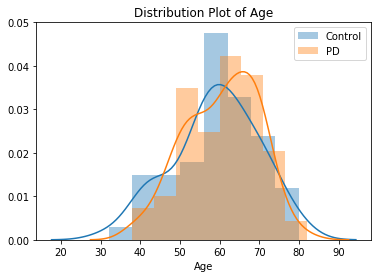

In [0]:
# seaborn distribution plot of Age
sns.distplot(df_control.Age, rug=False, label='Control')
sns.distplot(df_pd.Age, rug=False, label='PD')
plt.title('Distribution Plot of Age')
plt.legend()
plt.show() # pd has a slightly older distribution than control

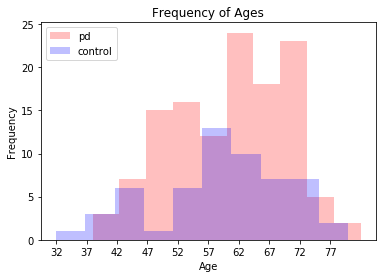

In [0]:
# plot for the ages
plt.hist(df_pd.Age, align='mid', alpha=0.25, color='r', label='pd', bins=10)
plt.hist(df_control.Age, align='mid', alpha=0.25, color='b', label='control', bins=10)
plt.legend(loc='upper left')

# set labels
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Frequency of Ages')

# set ticks
plt.xticks(np.arange(min(df_control.Age), max(df_control.Age)+1, 5.0))
plt.show()

No handles with labels found to put in legend.


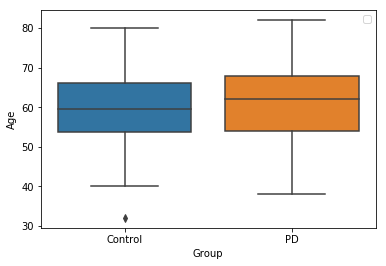

In [0]:
# some boxplots
sns.boxplot(x="Group", y="Age", data=patient_df)
plt.legend()
plt.xticks([0, 1], ['Control', 'PD'])

plt.show()

In [0]:
## Gender Distributions
print ("For Control:")
print (np.unique(df_control.Sex.values, return_counts=True))
print ("For PD")
print (np.unique(df_pd.Sex.values, return_counts=True)) # very visible from results males are more likely to get pd..

For Control:
(array(['F', 'M'], dtype=object), array([15, 41]))
For PD
(array(['F', 'M'], dtype=object), array([46, 79]))


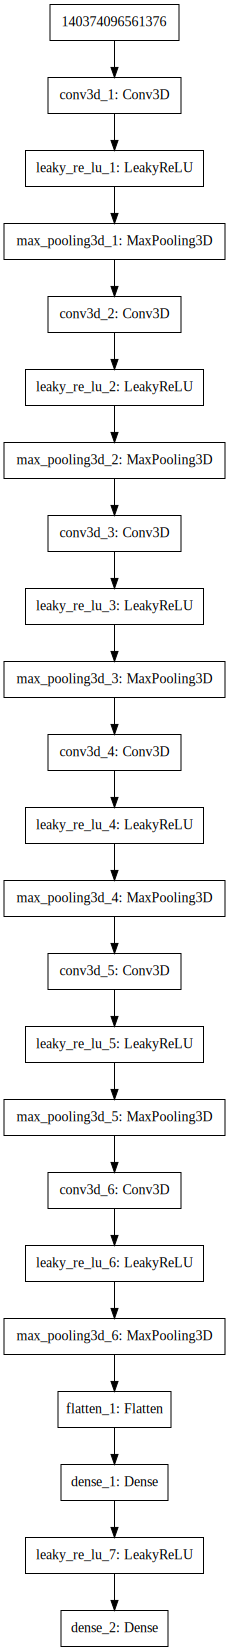

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train on 64 samples, validate on 17 samples
Epoch 1/10
64/64 [==============================] - 7s 114ms/step - loss: 0.1900 - acc: 0.9375 - val_loss: 2.4008 - val_acc: 0.4118
Epoch 2/10
64/64 [==============================] - 7s 113ms/step - loss: 0.1942 - acc: 0.9375 - val_loss: 0.7828 - val_acc: 0.5294
Epoch 3/10
64/64 [==============================] - 7s 114ms/step - loss: 0.1106 - acc: 0.9688 - val_loss: 2.0604 - val_acc: 0.4706
Epoch 4/10
64/64 [==============================] - 7s 115ms/step - loss: 0.0373 - acc: 1.0000 - val_loss: 1.3764 - val_acc: 0.4706
Epoch 5/10
64/64 [==============================] - 7s 115ms/step - loss: 0.0365 - acc: 1.0000 - val_loss: 1.6944 - val_acc: 0.4706
Epoch 6/10
64/64 [==============================] - 7s 115ms/step - loss: 0.0283 - acc: 1.0000 - val_loss: 1.7637 - val_acc: 0.4706
Epoch 7/10
64/64 [==============================] - 7s 114ms/step - loss: 0.0209 - acc: 1.0000 - val_loss: 1.7055 - val_acc: 0.4706
Epoch 8/10
64/64 [==============

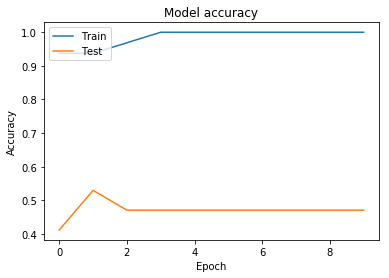

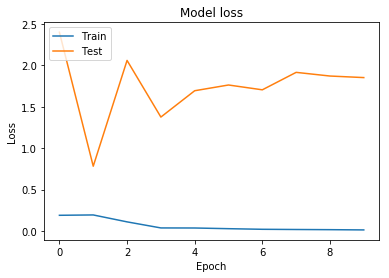

In [0]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=5, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Build a NN that feeds in age and sex as inputs (two inputs), classifying to PD**

In [0]:
# define function to get age and sex
def get_age_sex(s):
  sex = s[1]
  age = s[3].astype(np.int)
  return np.array((sex, age))

# create age_sex array
age_sex = np.array([get_age_sex(s) for s in total_slices_info])

In [0]:
# get the new df
patient_df = pd.read_pickle('processed_patient_df_TRY2.pkl')


In [0]:
# Get age and sex
age_sex = patient_df[['Sex', 'Age']].values
group = patient_df['Group'].values

# build deep learning framework to classify


**Put into one super class which we can load our data (overwrite), fit and continue**

In [0]:
from keras.models import load_model
num_epochs = 3
batch_size = 10

batches_path = os.getcwd() + '/stored_batches'

for batch_pkl in os.listdir(batches_path):
  batch_pkl_path = batches_path + '/' + batch_pkl
  
  # load up the batch
  with open(batch_pkl_path, 'rb') as f:
    total_slices, total_slices_info = pickle.load(f)
    
  # get the corresponding y-values
  y_values = get_y_values(total_slices_info)
  
  # split into training and test set
  X_train, X_test, y_train, y_test = train_test_split(total_slices, y_values, test_size=0.2, shuffle=True)
  
  # fit to our existing model
  model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, # can modify batch size and epochs
          validation_data=(X_test, y_test), shuffle=True)

# creates a file and saves it (architecture, weights, optimizer)
model.save('my_model.h5', overwrite=True)  # creates a HDF5 file 'my_model.h5'
# model = load_model('my_model.h5')